# EDA - MIDI files and artists representation

In [2]:
import os
import pretty_midi
import midi_access as midi
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

sns.set_theme(style="whitegrid")

In [3]:
BASE_MIDI_DIR = './dataset_module_7'  
ARTISTS_DIR = os.path.join(BASE_MIDI_DIR, 'all_files')

artist_midi_dict = midi.load_midi_files_by_artist(ARTISTS_DIR)
artist = 'Bach'
# Now artist_midi_dict maps each artist to a list of their MIDI data

/opt/homebrew/anaconda3/envs/masters/lib/python3.12/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


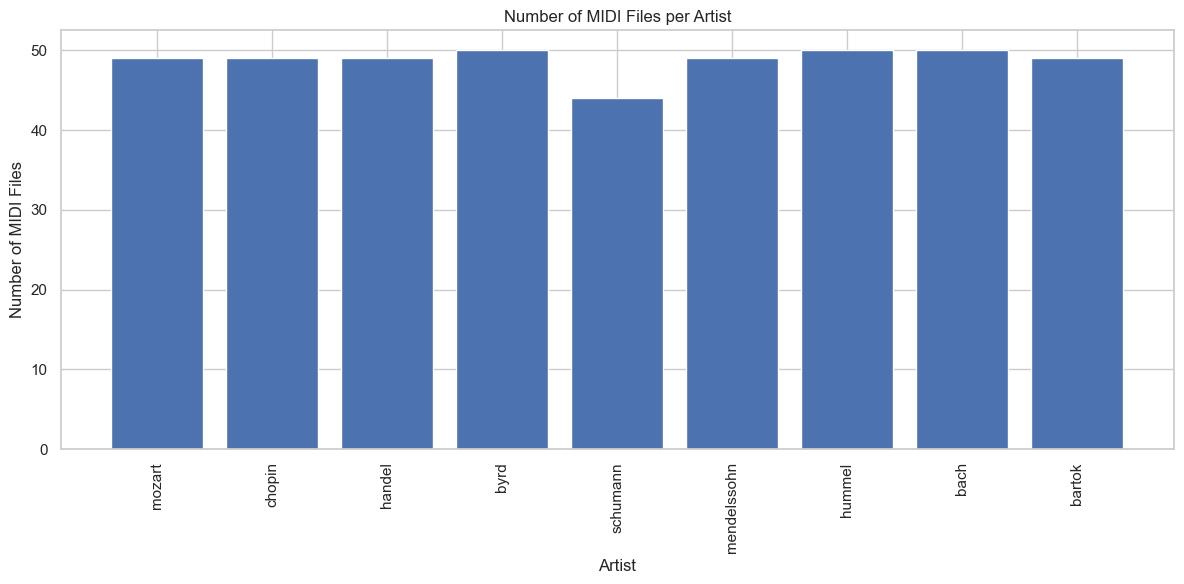

In [4]:
# Count number of MIDI files per artist
artist_counts = {artist: len(midi_list) for artist, midi_list in artist_midi_dict.items()}

# Bar chart of MIDI files per artist
plt.figure(figsize=(12, 6))
plt.bar(artist_counts.keys(), artist_counts.values())
plt.xticks(rotation=90)
plt.xlabel('Artist')
plt.ylabel('Number of MIDI Files')
plt.title('Number of MIDI Files per Artist')
plt.tight_layout()
plt.show()

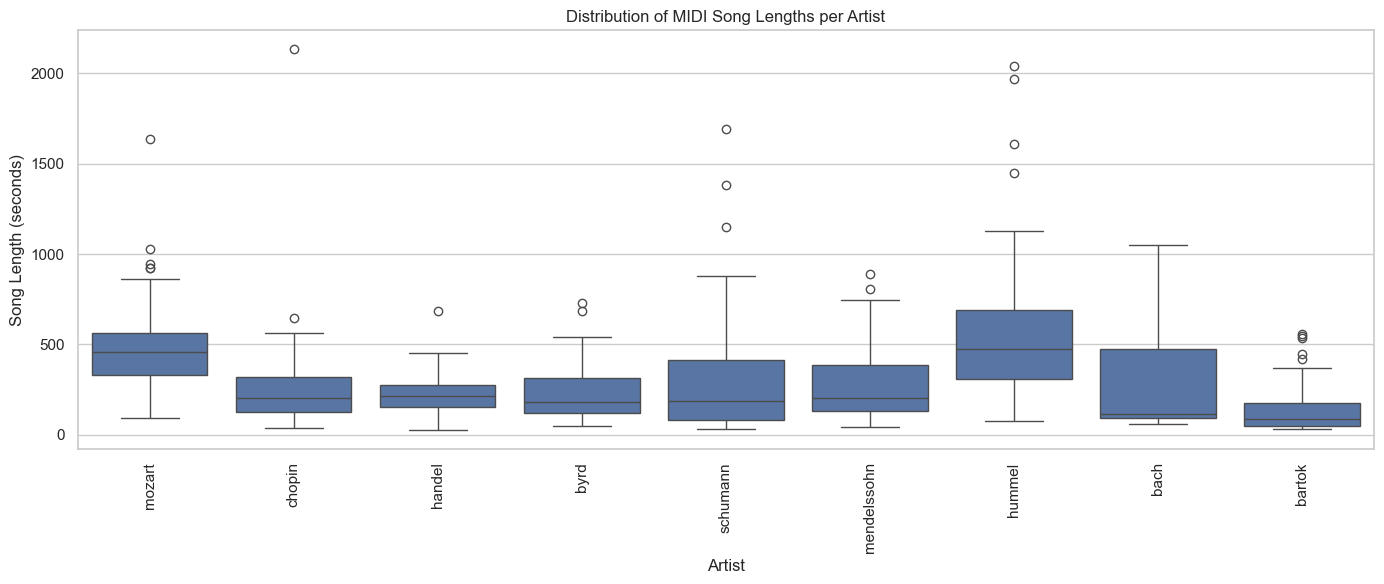

In [5]:
# Collect lengths and artists
data = []
for artist, midi_list in artist_midi_dict.items():
    for midi_data in midi_list:
        length = midi_data.get_end_time()
        data.append({'artist': artist, 'length': length})

df = pd.DataFrame(data)

plt.figure(figsize=(14, 6))
sns.boxplot(x='artist', y='length', data=df)
plt.xticks(rotation=90)
plt.xlabel('Artist')
plt.ylabel('Song Length (seconds)')
plt.title('Distribution of MIDI Song Lengths per Artist')
plt.tight_layout()
plt.show()

# Artist feature examples

we can use these features in order to create a classification

In [6]:
top_chords = midi.get_top_chords(artist_midi_dict, top_n=20)

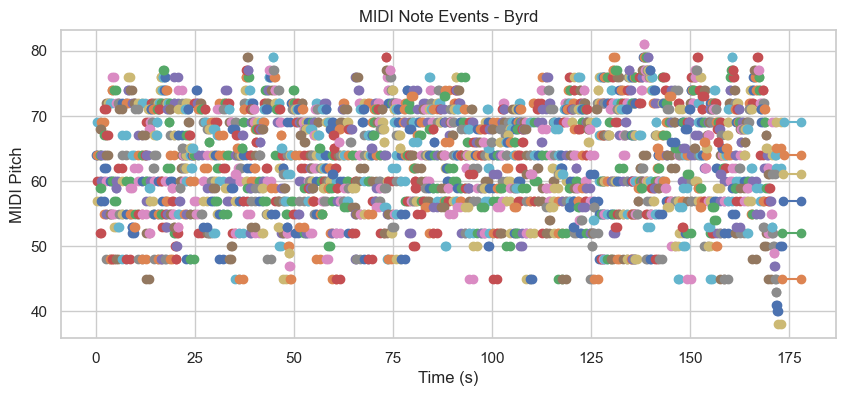

In [7]:
midi_data = artist_midi_dict[artist][0]  


# Visualize the MIDI data
def visualize_midi(midi_data):
    plt.figure(figsize=(10, 4))
    plt.title(f'MIDI Note Events - {artist}')
    for instrument in midi_data.instruments:
        for note in instrument.notes:
            plt.plot([note.start, note.end], [note.pitch, note.pitch], marker='o')
    plt.xlabel('Time (s)')
    plt.ylabel('MIDI Pitch')
    plt.show()

visualize_midi(midi_data)

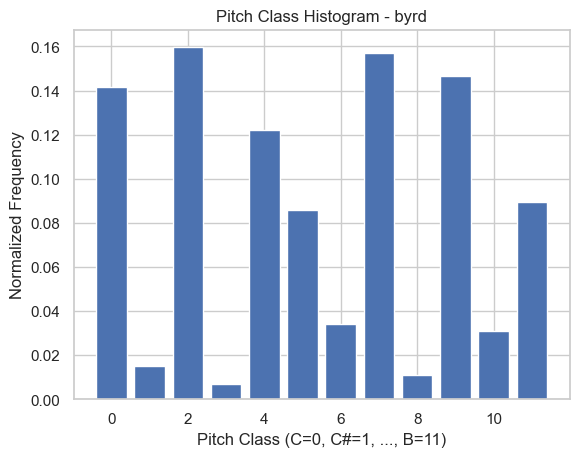

In [8]:
# Aggregate for all MIDI files of an artist
pitch_class_hist = np.zeros(12)
for song in artist_midi_dict[artist]:
    pitch_class_hist += midi.get_pitch_class_histogram(song)
pitch_class_hist /= len(artist_midi_dict[artist])

plt.bar(range(12), pitch_class_hist)
plt.xlabel('Pitch Class (C=0, C#=1, ..., B=11)')
plt.ylabel('Normalized Frequency')
plt.title(f'Pitch Class Histogram - {artist}')
plt.show()

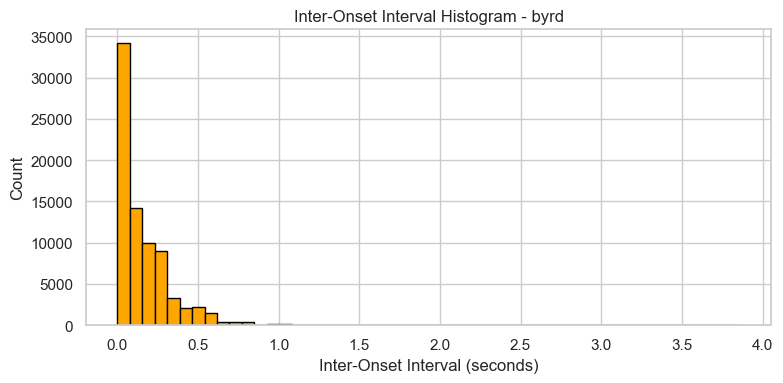

In [9]:
def get_inter_onset_intervals(midi_data):
    # Collect all note start times
    onsets = []
    for instrument in midi_data.instruments:
        for note in instrument.notes:
            onsets.append(note.start)
    onsets = np.sort(onsets)
    # Compute differences between consecutive onsets
    iois = np.diff(onsets)
    return iois

all_iois = []
for song in artist_midi_dict[artist]:
    iois = get_inter_onset_intervals(song)
    all_iois.extend(iois)


plt.figure(figsize=(8, 4))
plt.hist(all_iois, bins=50, color='orange', edgecolor='black')
plt.xlabel('Inter-Onset Interval (seconds)')
plt.ylabel('Count')
plt.title(f'Inter-Onset Interval Histogram - {artist}')
plt.tight_layout()
plt.show()

Chord (2, 7, 11): 1583 times
Chord (0, 4, 7): 1327 times
Chord (2, 6, 9): 798 times
Chord (0, 4): 760 times
Chord (0, 5, 9): 676 times
Chord (0, 9): 673 times
Chord (7, 11): 601 times
Chord (4, 7): 591 times
Chord (5, 9): 587 times
Chord (2, 5, 9): 559 times
Chord (2, 11): 545 times
Chord (2, 7): 519 times
Chord (2, 5): 507 times
Chord (0, 4, 9): 405 times
Chord (1, 4, 9): 402 times


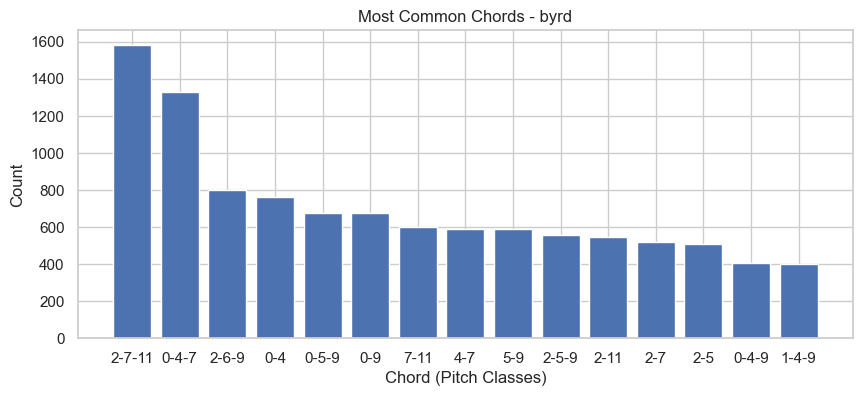

In [10]:
chord_counter = Counter()
for song in artist_midi_dict[artist]:
    chords = midi.extract_chords(song)
    chord_counter.update(chords)

# Show the most common chords (as pitch class sets)
most_common_chords = chord_counter.most_common(15)
for chord, count in most_common_chords:
    print(f"Chord {chord}: {count} times")

# Optional: Bar plot of top chords
labels = ['-'.join(map(str, chord)) for chord, _ in most_common_chords]
counts = [count for _, count in most_common_chords]
plt.figure(figsize=(10, 4))
plt.bar(labels, counts)
plt.xlabel('Chord (Pitch Classes)')
plt.ylabel('Count')
plt.title(f'Most Common Chords - {artist}')
plt.show()

## Create a Features Tensor

In [11]:
# Example: get tensor for 'Bach'
feature_tensor = midi.get_artist_feature_tensor(artist_midi_dict[artist], top_chords)
print("Feature tensor shape:", feature_tensor.shape)
print("Feature tensor:", feature_tensor)

Feature tensor shape: (52,)
Feature tensor: [1.41523401e-01 1.48827877e-02 1.59685192e-01 6.96690525e-03
 1.21980856e-01 8.59345311e-02 3.41166959e-02 1.57017321e-01
 1.08764584e-02 1.46653362e-01 3.10964737e-02 8.92660166e-02
 4.39101731e+00 2.40610898e+00 1.48017898e+00 6.52200329e-01
 2.71637597e-01 5.43239300e-01 8.67504682e-02 8.78293397e-02
 2.97288857e-02 1.72802685e-02 2.06668216e-02 8.59733908e-03
 1.00730272e-03 3.24055069e-04 3.13088929e-04 1.97317674e-03
 5.51823589e-04 8.60955661e-05 1.80668473e-04 3.28174055e-04
 1.30167221e-01 7.82420192e-02 5.86485906e-02 5.72647624e-02
 7.08850405e-02 1.30418464e-02 1.27874416e-01 1.00718027e-02
 6.93110020e-02 5.62437035e-02 1.37155437e-02 5.38289526e-02
 6.00560114e-03 4.14445878e-02 2.47822981e-02 2.26205366e-02
 1.07889872e-02 6.30468324e-02 2.64236626e-02 6.55925979e-02]


# Artist diferentiation

Determining which features have better variance between artists



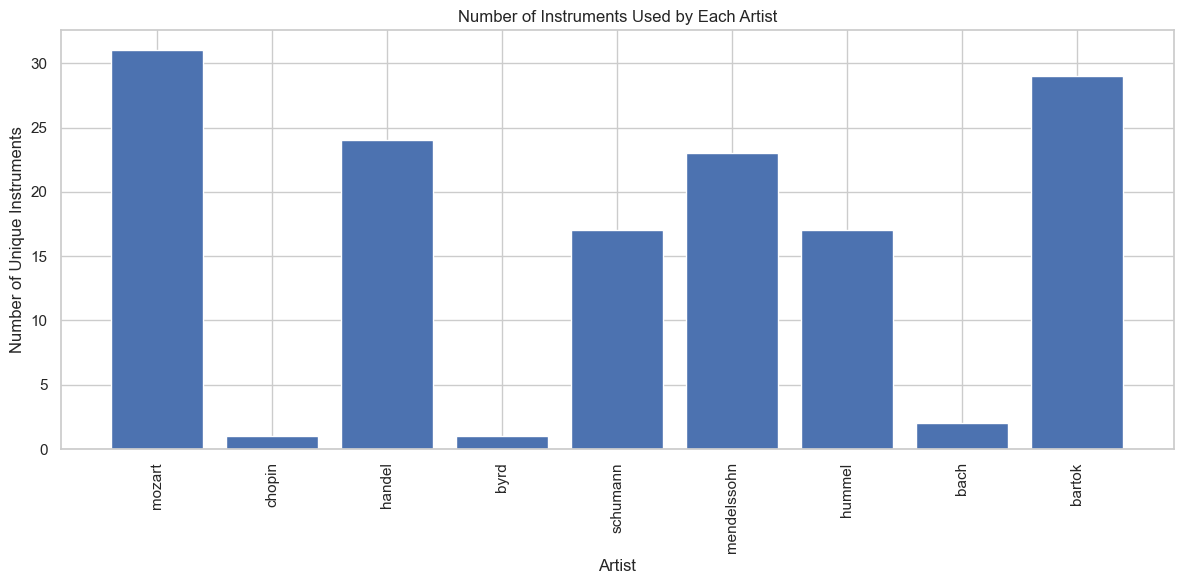

In [26]:
# Count unique instruments per artist
num_instruments_by_artist = {}
for artist, midi_list in artist_midi_dict.items():
    instruments = set()
    for midi_data in midi_list:
        for inst in midi_data.instruments:
            instruments.add(inst.program)
    num_instruments_by_artist[artist] = len(instruments)

plt.figure(figsize=(12, 6))
plt.bar(num_instruments_by_artist.keys(), num_instruments_by_artist.values())
plt.xticks(rotation=90)
plt.xlabel('Artist')
plt.ylabel('Number of Unique Instruments')
plt.title('Number of Instruments Used by Each Artist')
plt.tight_layout()

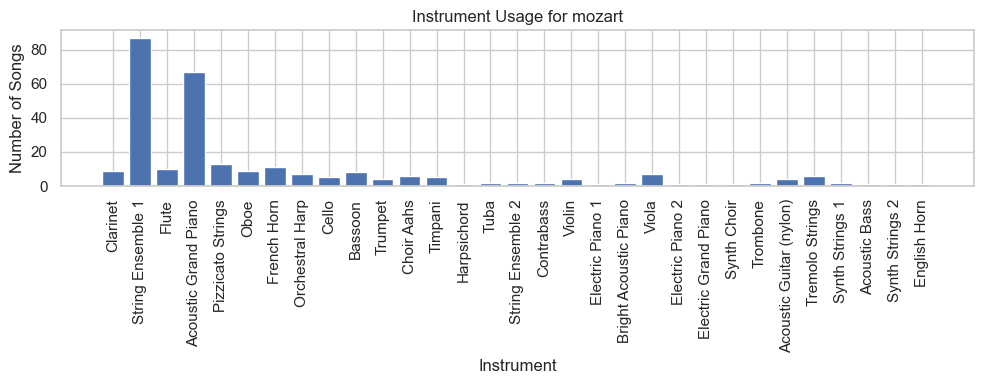

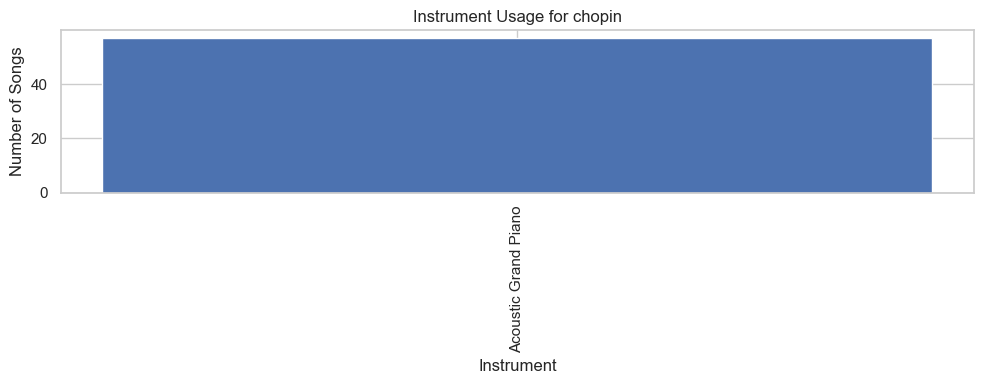

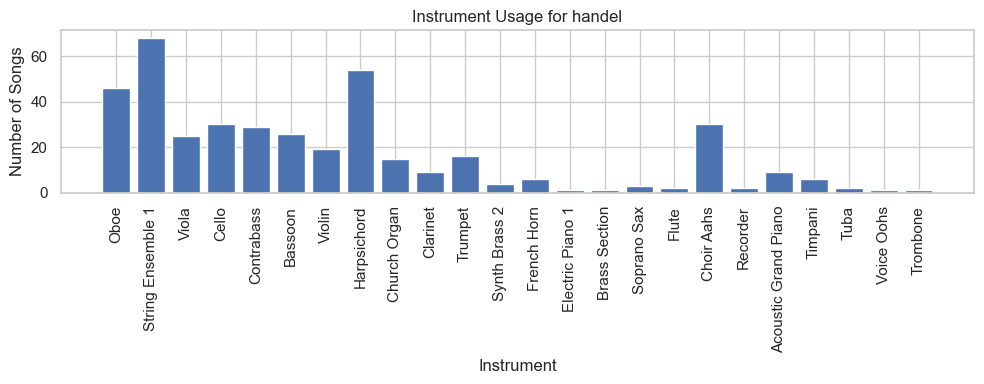

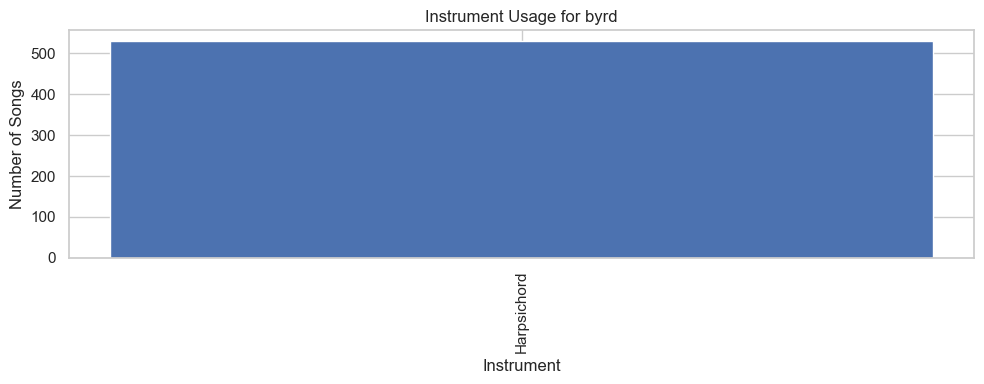

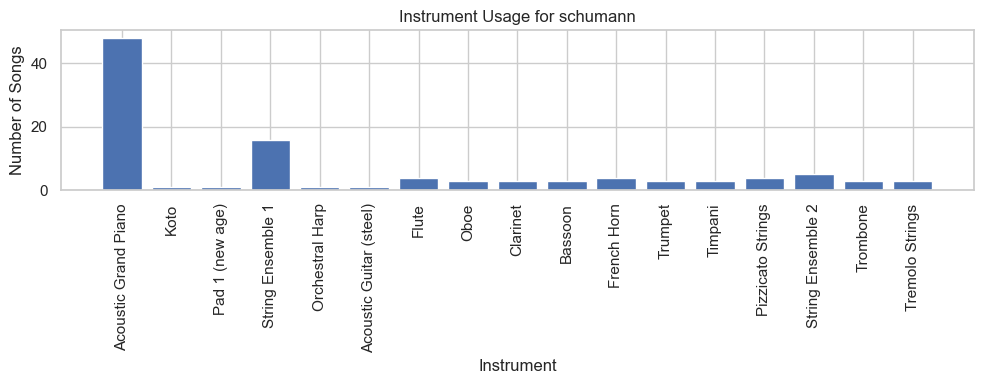

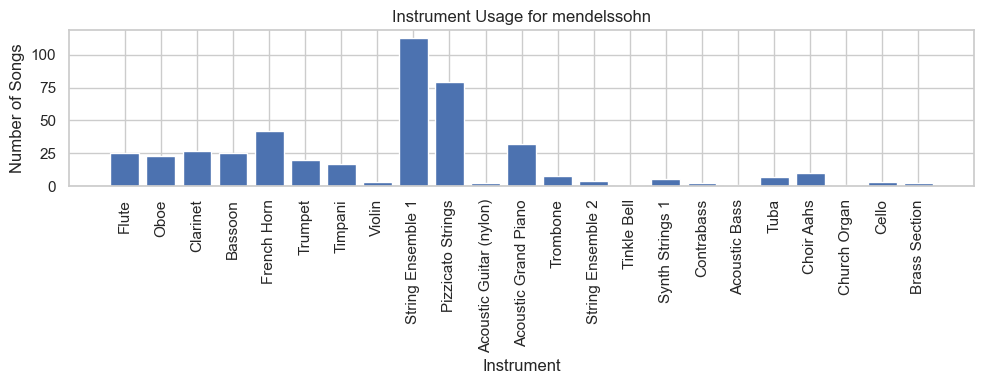

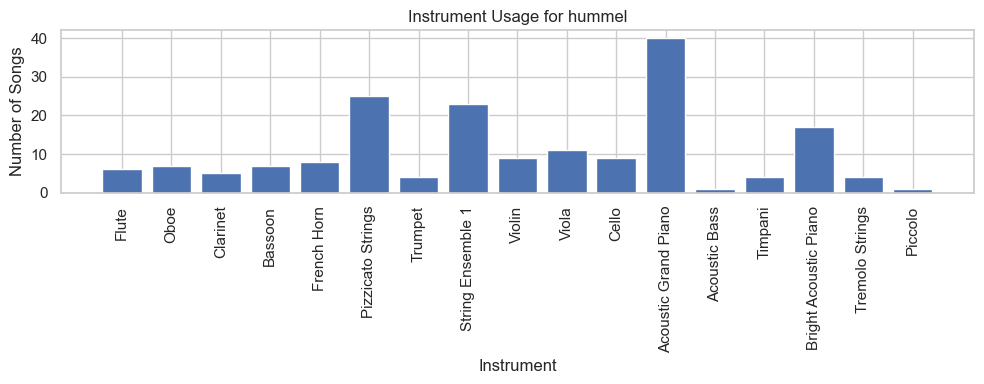

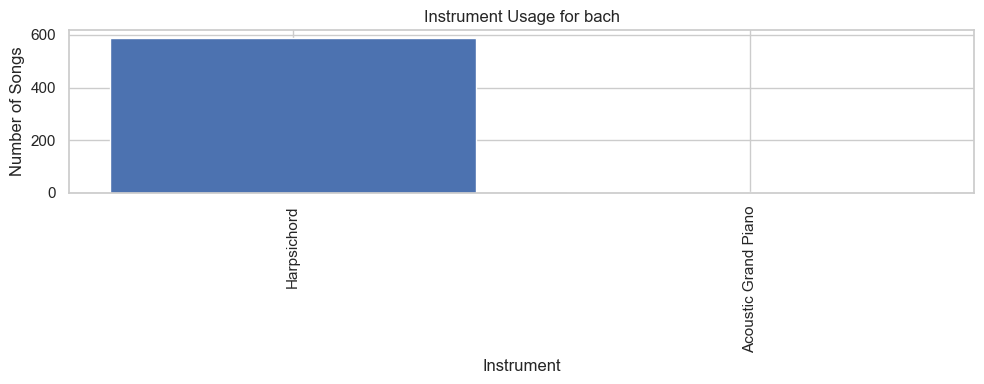

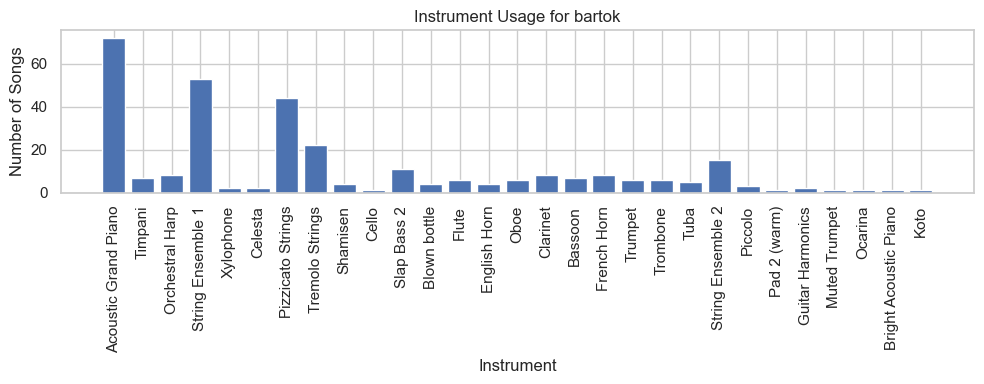

In [28]:
for artist, midi_list in artist_midi_dict.items():
    instruments = set()
    for midi_data in midi_list:
        for inst in midi_data.instruments:
            instruments.add(inst.program)
    instrument_names = [pretty_midi.program_to_instrument_name(prog) for prog in instruments]


for artist, midi_list in artist_midi_dict.items():
    instrument_counter = Counter()
    for midi_data in midi_list:
        for inst in midi_data.instruments:
            instrument_counter[inst.program] += 1
    instrument_names = [pretty_midi.program_to_instrument_name(prog) for prog in instrument_counter.keys()]
    counts = list(instrument_counter.values())
    plt.figure(figsize=(10, 4))
    plt.bar(instrument_names, counts)
    plt.xticks(rotation=90)
    plt.title(f'Instrument Usage for {artist}')
    plt.xlabel('Instrument')
    plt.ylabel('Number of Songs')
    plt.tight_layout()
    plt.show()

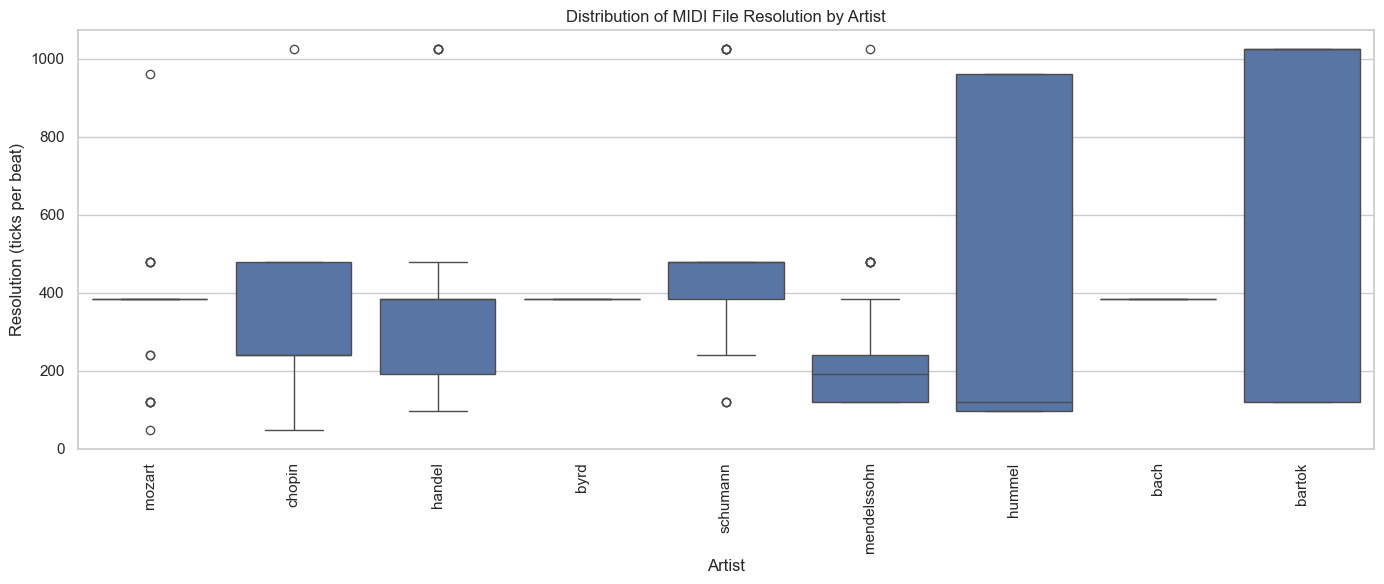

In [27]:
# Resolution of the MIDI files
'''
Resolution typically refers to the smallest unit of time 
that can be distinguished or represented in your MIDI data.

For MIDI files, this is often called "ticks per beat" or "PPQ" (Pulses Per Quarter note). 
It determines how finely you can represent timing, note onsets, durations, 
and other temporal events in the music. 
Higher resolution means more precise timing information.
'''
import matplotlib.pyplot as plt

# Collect resolution for each song
resolution_data = []
for artist, midi_list in artist_midi_dict.items():
    for midi_data in midi_list:
        resolution_data.append({'artist': artist, 'resolution': midi_data.resolution})

df_resolution = pd.DataFrame(resolution_data)

plt.figure(figsize=(14, 6))
sns.boxplot(x='artist', y='resolution', data=df_resolution)
plt.xticks(rotation=90)
plt.xlabel('Artist')
plt.ylabel('Resolution (ticks per beat)')
plt.title('Distribution of MIDI File Resolution by Artist')
plt.tight_layout()
plt.show()

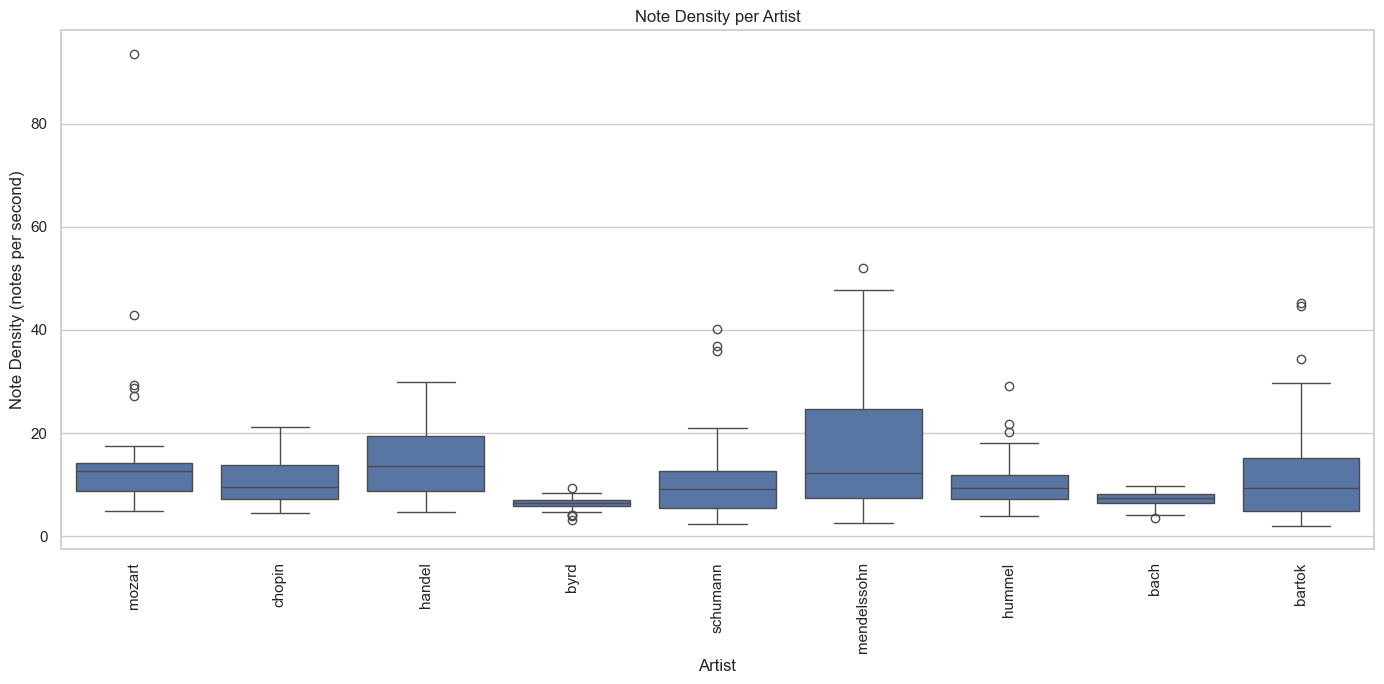

In [30]:
import pandas as pd

# Assuming artist_midi_dict is loaded using your midi_access.py
note_density_data = []
for artist, midi_list in artist_midi_dict.items():
    for midi_data in midi_list:
        num_notes = sum(len(inst.notes) for inst in midi_data.instruments)
        duration = midi_data.get_end_time()
        if duration > 0:
            note_density = num_notes / duration
            note_density_data.append({'artist': artist, 'note_density': note_density})

# Aggregate into DataFrame
df_note_density = pd.DataFrame(note_density_data)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 7))
sns.boxplot(x='artist', y='note_density', data=df_note_density)
plt.xticks(rotation=90)
plt.xlabel('Artist')
plt.ylabel('Note Density (notes per second)')
plt.title('Note Density per Artist')
plt.tight_layout()
plt.show()


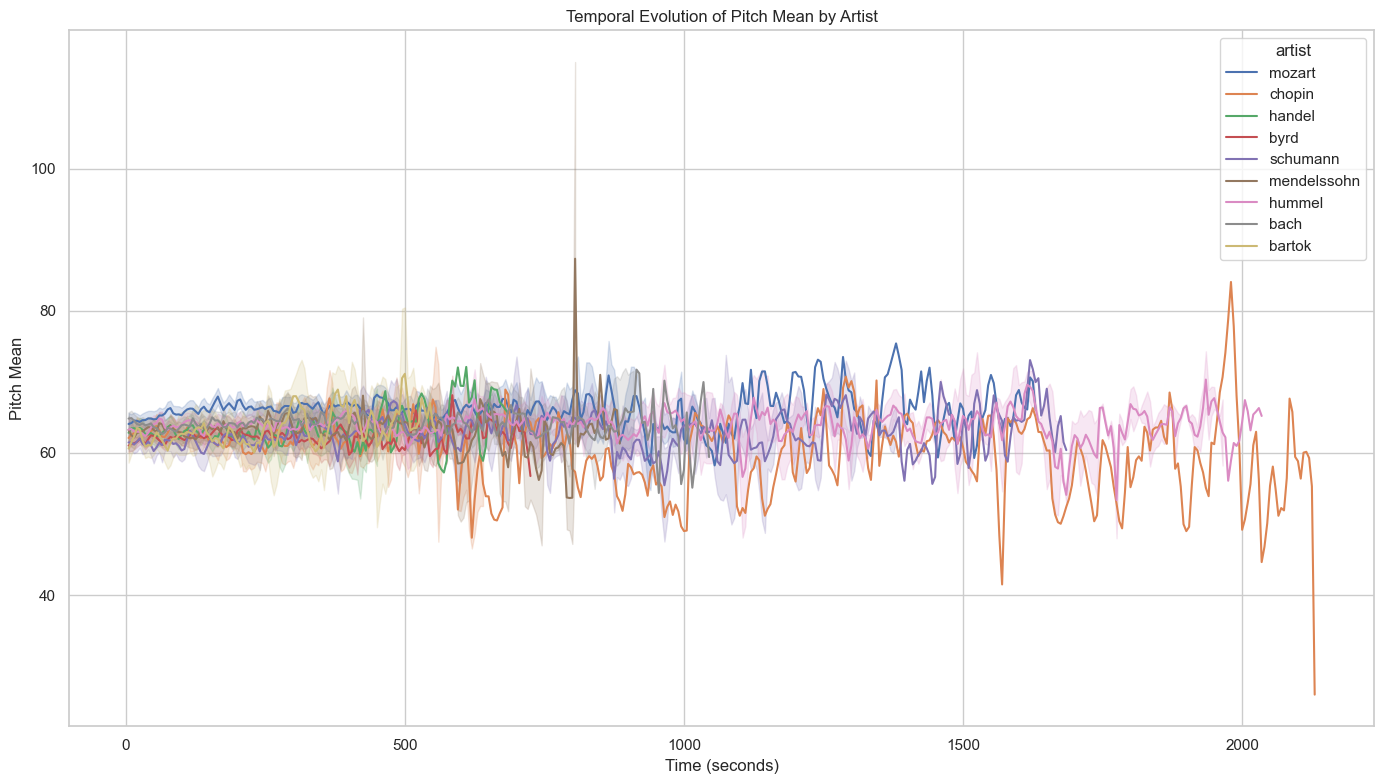

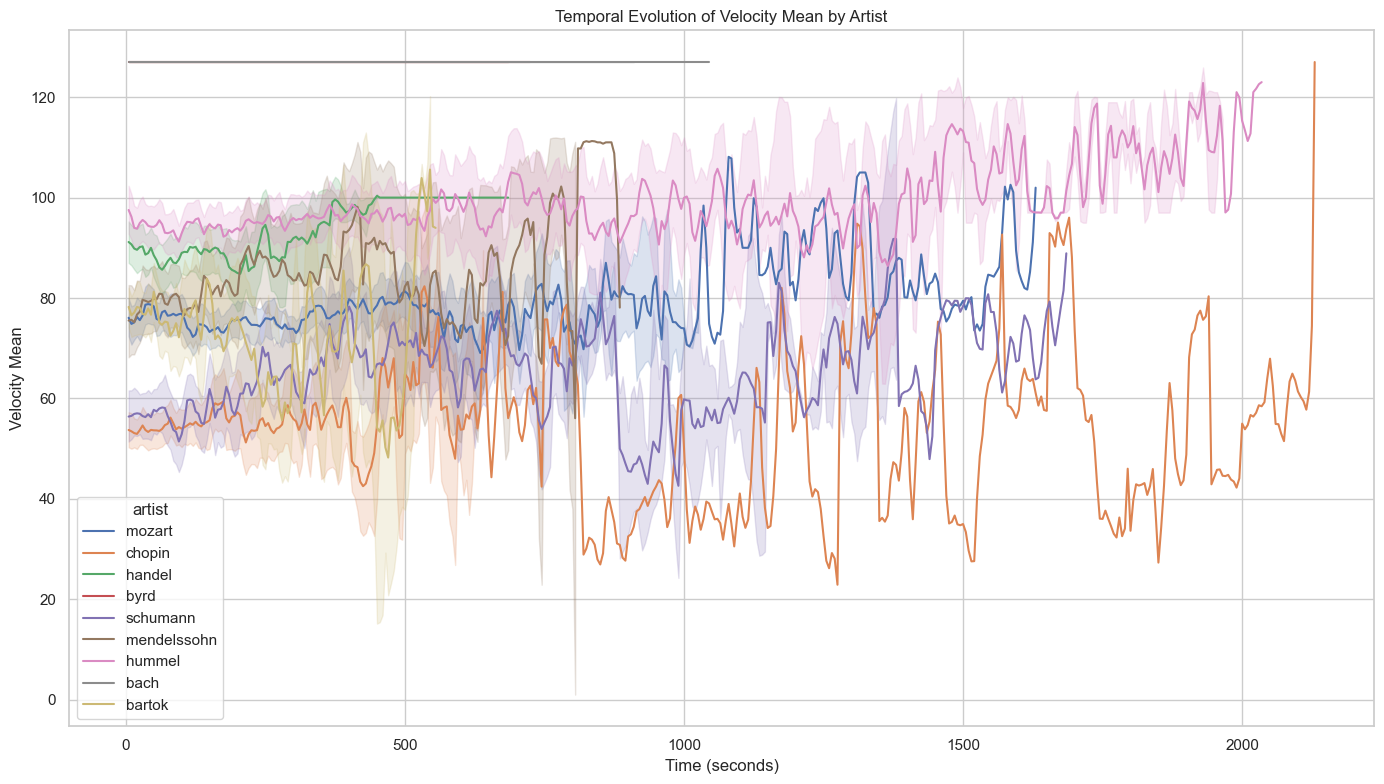

In [39]:
import numpy as np
import pandas as pd

def extract_rolling_features(midi_data, window_size=10.0, step_size=5.0):
    max_time = midi_data.get_end_time()
    start_times = np.arange(0, max_time - window_size + step_size, step_size)
    pitch_means, velocity_means, key_change_counts, times = [], [], [], []

    for start in start_times:
        end = start + window_size
        notes_in_window = []
        velocities_in_window = []
        for inst in midi_data.instruments:
            for note in inst.notes:
                if note.start >= start and note.start < end:
                    notes_in_window.append(note.pitch)
                    velocities_in_window.append(note.velocity)
        pitch_mean = np.mean(notes_in_window) if notes_in_window else np.nan
        velocity_mean = np.mean(velocities_in_window) if velocities_in_window else np.nan
        key_changes = [
            ksc.time for ksc in getattr(midi_data, 'key_signature_changes', [])
            if start <= ksc.time < end
        ]
        key_change_count = len(key_changes)
        pitch_means.append(pitch_mean)
        velocity_means.append(velocity_mean)
        key_change_counts.append(key_change_count)
        times.append(start + window_size / 2)
    return pd.DataFrame({
        'time': times,
        'pitch_mean': pitch_means,
        'velocity_mean': velocity_means,
        'key_change_count': key_change_counts
    })


# Create a dataframe for all artists' rolling features
df_list = []
for artist, midi_list in artist_midi_dict.items():
    for midi_data in midi_list:
        features = extract_rolling_features(midi_data)
        features['artist'] = artist
        df_list.append(features)

df_features = pd.concat(df_list, ignore_index=True)



plt.figure(figsize=(14, 8))
sns.lineplot(data=df_features, x='time', y='pitch_mean', hue='artist', legend='full')
plt.title('Temporal Evolution of Pitch Mean by Artist')
plt.xlabel('Time (seconds)')
plt.ylabel('Pitch Mean')
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 8))
sns.lineplot(data=df_features, x='time', y='velocity_mean', hue='artist', legend='full')
plt.title('Temporal Evolution of Velocity Mean by Artist')
plt.xlabel('Time (seconds)')
plt.ylabel('Velocity Mean')
plt.tight_layout()
plt.show()
